### Note that you have to load the following cell first, do not try to load the all notebook unless you already have load that cell.

In [1]:
%gui qt5

# Notebook use to analyse one specific file.

You can click `shift` + `enter` to run one cell, you can also click run in top menu.
To run all the cells, you can click `kernel` and `Restart and run all` in the top menu.

In [30]:
import time
tp1 = time.time()

In [2]:
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Matplotlib to plot the data
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = 12,12
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
import napari

In [6]:
# Some module needed in the notebook
import numpy as np
import javabridge
import bioformats
from itkwidgets import view
from sklearn.externals import joblib

### The following path should direct to the folder "utils", on Window env it should have slash " / " and not backslash " \ " . 

In [7]:
# Create a temporary python PATH to the module that we are using for the analysis
import sys
sys.path.insert(0, "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/utils")

In [8]:
from chromosome_dsb import *

In [9]:
# Need to create a javabridge to use bioformats to open proprietary format
javabridge.start_vm(class_path=bioformats.JARS)

### In the path_data variable you should enter the path to your data:

In [10]:
path_data = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/cku-exo1_002/'

In [11]:
position, time_point = load_data.stage_position(path_data)

# Set Parameters

In [12]:
# Size kernel for background substraction, should be a little larger than the object of interest
back_sub_FOCI = 5
back_sub_Nucleus = 20
# LOCI detection:
# Smallest object (in pixels) to be detected
smaller = 1
# Largest object to be detected
largest = 5
# Threshold above which to look for
threshold = 18000    

# Find "Skeleton" of gonad

In [13]:
skelete = load_data.skeleton_coord(position,time_point)

Polyfit may be poorly conditioned


# Load Image

### In the path_img you can enter the name of your specific image "/....dv"

In [14]:
path_img = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/2019-09-16_CG015_mpiMSH5_rbtGFP_chkHTP3_AV630_001_visit_17_D3D_ALX.dv'

In [15]:
image, meta, directory = load_data.load_bioformats(path_img)

In [18]:
print("image type:", image.dtype)
print("image shape:", image.shape)
print("image min:", image.min())
print("image max:", image.max())
print("image size in Mb:", image.nbytes)

image type: float64
image shape: (61, 480, 480, 4)
image min: -549.7520751953125
image max: 262525.875
image size in Mb: 449740800


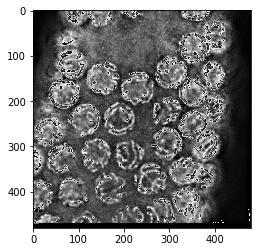

In [19]:
plt.imshow(image[32,:,:,3].astype("uint16"))

# Plot "Skeleton" of gonad

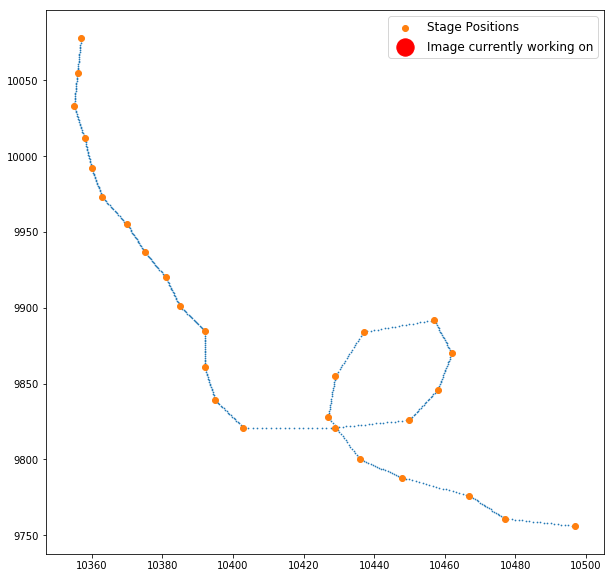

In [22]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
#working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
plt.legend([stage_pos, working_on], ["Stage Positions", 
                                     "Image currently working on"],
                                      loc=0,fontsize='large')
#plt.savefig('/Users/Espenel/Desktop/skeleton.png', bbox_inches="tight", pad_inches=0)

In [23]:
img = image[:,:,:,3]

In [24]:
viewer = napari.Viewer(ndisplay=3)

In [25]:
viewer.add_image(image[:,:,:,3])

<Image layer 'Image' at 0x11358cc90>

In [26]:
#Nucleus_ch_norm = (Nucleus_ch - np.mean(Nucleus_ch)) / (np.max(Nucleus_ch) - np.min(Nucleus_ch))

In [27]:
#Nucleus_ch_norm.min()

(-0.5, 479.5, 479.5, -0.5)

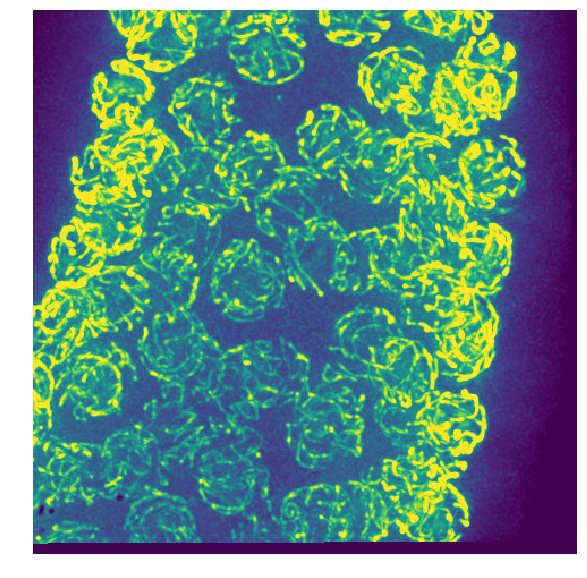

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.amax(img, axis=0), vmin = 10000, vmax = 100000, cmap = "viridis")
ax.axis('off')
#plt.savefig('/Users/Espenel/Desktop/ImageXD2019/overlap_nucleus.png')

### Optionally you can visualyze your data

In [ ]:
#view(visualization.convert_view(img))

# Find the nucleus in the image

### First need to load the classifier (clf) and scaler.

In [29]:
clf = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/clf")
scaler = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/scaler")

In [31]:
tp_1 = time.time()
result = search.rolling_window(img, clf, scaler)
tp_2 = time.time()
print(tp_2-tp_1)

136.45733189582825


In [32]:
bbox_ML = search.non_max_suppression(result, probaThresh=0.5, overlapThresh=0.3)

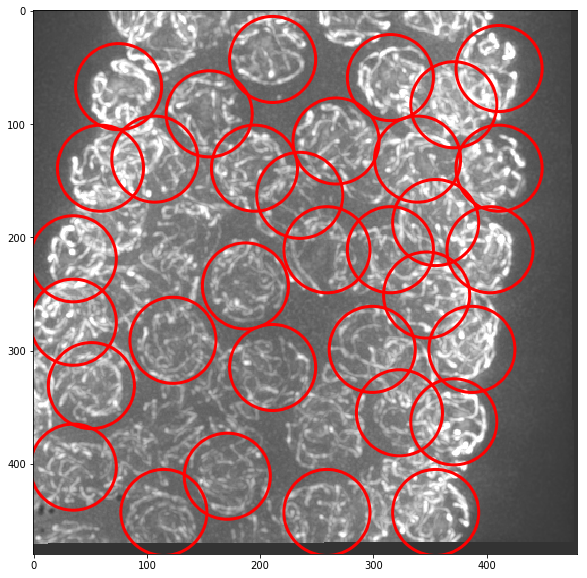

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.amax(img,axis=0), vmax=img.max()/2, alpha = 0.8)
for coord in bbox_ML:
    circles1 = patches.Circle((coord[0]+35,coord[1]+35),38, linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(circles1)

# Background Substraction

In [34]:
FOCI_ch, _ = img_analysis.background_correct(image, ch=1, size=back_sub_FOCI)
Nucleus_ch, _ = img_analysis.background_correct(image, ch=3, size=back_sub_Nucleus)

In [35]:
visualization.plot_background(image, FOCI_ch, Nucleus_ch)

interactive(children=(IntSlider(value=100, description='pos', max=479), Dropdown(description='channel', option…

# Finding the Blobs/FOCI

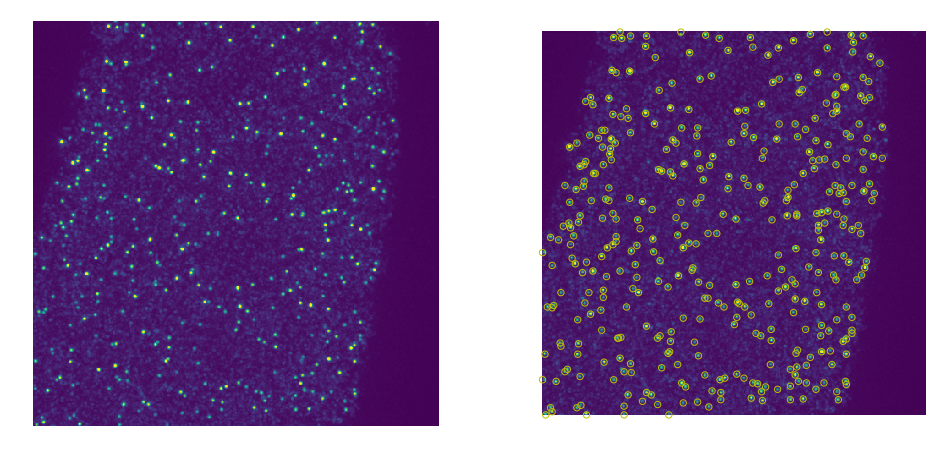

In [36]:
blobs = img_analysis.find_blob(FOCI_ch, meta, directory, smaller = smaller, 
                               largest = largest, thresh = threshold,
                               plot=True, save=True)

In [37]:
viewer.add_points(blobs[:,0:3], size =7, face_color='blue')

<Points layer 'Points' at 0x15886b090>

# Binarization of the Channel with nucleus

In [38]:
binary = img_analysis.binarization(Nucleus_ch)

In [39]:
#viewer.add_labels(binary)

In [40]:
viewer.add_points(np.flip(bbox_ML[:,0:2])+30, size =70, edge_color='red', face_color='black')

<Points layer 'Points 1' at 0x1759b4d10>

### Optionaly, you can visualyze the result of the binarization

In [ ]:
#view(visualization.convert_view(binary))

# Load the position of the different nucleus

In [ ]:
#bbox_ML = np.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/13/bbox_3D.npy")

# Mask FOCI that are not on the nucleus

In [41]:
masked = search.find_foci(blobs, FOCI_ch, Nucleus_ch, binary, bbox_ML)

# Mask FOCI that are not on a nucleus found by the Machine Learning

In [42]:
res, bb_mask = search.binary_select_foci(bbox_ML, Nucleus_ch, masked)

# Find and remove FOCI that were counted twice

In [43]:
num, cts, dup_idx, mask = search.find_duplicate(res, bb_mask)

In [44]:
z,x,y = np.where(masked)

In [45]:
viewer.add_points(np.squeeze(np.dstack((z, x,y))), size =15, face_color='red')

<Points layer 'Points 2' at 0x160b7d9d0>

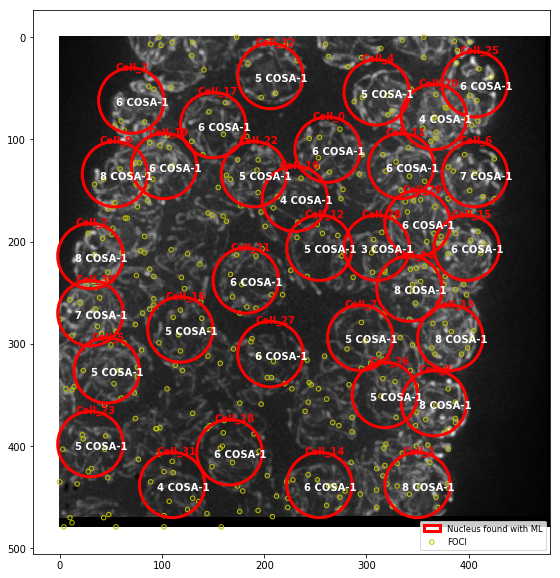

In [47]:
visualization.plot_result(img, blobs, bbox_ML,\
                          cts, num, meta, directory, save = False)

In [48]:
from sklearn.neighbors import KDTree

In [49]:
tree = KDTree(skelete)

In [50]:
tree

In [51]:
coords = np.copy(bbox_ML[:,0:2])
coords[:,0] = (coords[:,0]+35)*meta['PhysicalSizeX'] + meta['PositionX']-19
coords[:,1] = (480 - (coords[:,1]+35))*meta['PhysicalSizeY'] + meta['PositionY']-19

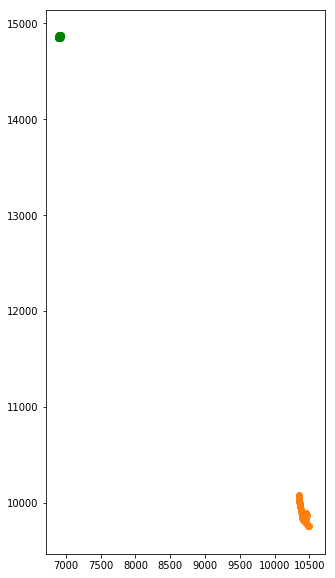

In [52]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(5, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
ax.scatter(coords[:,0], coords[:,1], c='g')
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
#working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
#plt.legend([stage_pos, working_on], ["Stage Positions", 
#                                     "Image currently working on"],
#                                      loc=0,fontsize='large')
plt.savefig('/Users/Espenel/Desktop/skeleton_1.png', bbox_inches="tight", pad_inches=0)

In [53]:
dist_tip = img_analysis.distance_to_tip(bbox_ML, skelete, meta)

In [54]:
chro_pos = np.squeeze(np.dstack((bbox_ML[:,0]+35,
                          bbox_ML[:,1]+35, bbox_ML[:,4])))

In [55]:
df = img_analysis.final_table(meta, bbox_ML,  \
                         dist_tip, cts, num, \
                         directory, save = False)

In [56]:
df

,Image ID,Chromosome position x,Chromosome position y,Chromosome position z,Chromosome position x in stage coordinate,Chromosome position y in stage coordinate,distance from tip in um,Numbers of FOCI,cell number on image
0,17,115,267,0,6912,14872,5905,6,0
1,17,443,355,20,6919,14845,5879,8,1
2,17,219,35,16,6893,14864,5910,8,2
3,17,67,75,16,6897,14876,5917,6,3
4,17,59,315,4,6916,14876,5906,5,4
5,17,331,51,8,6895,14855,5901,5,5
6,17,139,411,16,6924,14870,5896,7,6
7,17,299,299,36,6915,14857,5891,5,7
8,17,363,371,20,6920,14852,5884,8,8
9,17,139,59,20,6895,14870,5913,8,9


In [57]:
to_save = {'back_sub_ch1' : back_sub_FOCI,
           'back_sub_ch2' : back_sub_Nucleus,
           'small_object' : smaller,
           'large_object' : largest,
           'threshold' : threshold}

log.log_file(directory, meta, **to_save)

In [58]:
tp2 = time.time()

In [59]:
print("It took {}sec".format(int(tp2-tp1)))

It took 394sec
